# Model training
Using a neural network for the recommender system

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as Functional
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
activites = pd.read_csv('activities.csv')
activites.head()

,id,type,description,url,lattitude,longitude,score
0,0,sport,climbing,https://www.facebook.com/groups/escaladeromand...,46.512947,6.624772,1
1,1,sport,badminton,http://www.badmintonlausanne.ch/,46.528290,6.601945,4
2,2,sport,swimming pool,https://www.lausanne-tourisme.ch/fr/decouvrir/...,46.522474,6.605101,3
3,3,sport,climbing,https://totem.ch/?ec,46.516749,6.548327,4
4,4,meditation,yoga,https://totem.ch/yoga#studio?smooth,46.516749,6.548327,4


In [3]:
# Read the CSV of interactions and sort it by timestamp
data = pd.read_csv('interactions.csv')
data_sorted = data.sort_values('timestamp')
data_sorted.head()

,user_id,item_id,rating,timestamp
0,1,0,1,1616193271
2,1,2,0,1616193911
1,1,1,1,1616194035
3,1,3,0,1616194210
4,0,2,2,1616194210


In [4]:
# Cut the data off at 75% in order to save some data for the test process
CUTOFF = 0.70
cutoff_idx = int(len(data_sorted) * CUTOFF)

# Generate the train and test data
data_train = data_sorted.iloc[0:cutoff_idx]
data_test = data_sorted.iloc[cutoff_idx:]

data_train.shape, data_test.shape

((8, 4), (4, 4))

In [5]:
def get_intersection_test_and_train(field):
    """
    Get interactions between the test and train datasets
    for the given field
    """

    return (
        set(data_test[field].unique())
        & set(data_train[field].unique())
    )


# Get the interactions between test and train for user_id and item_id
interactions_user, intractions_item = get_intersection_test_and_train('user_id'), get_intersection_test_and_train('item_id')

# Clean the test dataset to make sure it does not contain "solo" data
data_test_clean = (
    data_test.loc[
        data_test['user_id'].isin(interactions_user)
        & data_test['item_id'].isin(intractions_item)
    ]
)

data_test_clean.shape

(1, 4)

In [6]:
def is_test_data_all_in_train(field):
    return data_test_clean[field].isin(data_train[field]).all()

assert is_test_data_all_in_train('user_id')
assert is_test_data_all_in_train('item_id')

In [7]:
def create_mapping_from_data_train(field):
    return {elem: i for i, elem in enumerate(data_train[field].unique())}

user_to_id, item_to_id = create_mapping_from_data_train('user_id'), create_mapping_from_data_train('item_id')

def create_dataset_from_mapping(init_dataset, *fields):
    """
    Returns a clone of the dataset by applying the mappings
    created with `create_mapping_from_data_train` on each field
    listed in the parameters.  
    """

    mappings = {field: create_mapping_from_data_train(field) for field in fields}

    dataset = init_dataset.copy()

    for field in fields:
        dataset[field] = dataset[field].apply(lambda x: mappings[field][x])

    return dataset

dataset_train, dataset_test = create_dataset_from_mapping(data_train, 'user_id', 'item_id'), create_dataset_from_mapping(data_test_clean, 'user_id', 'item_id')
dataset_train.shape, dataset_test.shape

((8, 4), (1, 4))

In [8]:
def get_x_y(dataset, x_fields, y_field):
    return (
        dataset[x_fields].values,
        dataset[y_field].values
    )

X_train, y_train = get_x_y(
    dataset_train,
    ['user_id', 'item_id'],
    'rating'
)
X_test, y_test = get_x_y(
    dataset_test,
    ['user_id', 'item_id'],
    'rating'
)

## Implement neural network
In the following cell I will implemement a neural network instead of a Matrix Factorization to predict the scores for each recommendation

In [9]:
class NNRecommender(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors, hidden_1, dim_out):
        super().__init__()

        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

        self.linear_1 = torch.nn.Linear(n_factors*2, hidden_1)
        self.linear_2 = torch.nn.Linear(hidden_1, dim_out)

    def forward(self, user_ids, item_ids):
        users_embedding = self.user_factors(user_ids)
        items_embedding = self.item_factors(item_ids)

        x = torch.cat([
            users_embedding,
            items_embedding,
        ], 1)
        h1_relu = Functional.relu(self.linear_1(x))
        output = self.linear_2(h1_relu)

        return torch.squeeze(output)
    
    def predict(self, user, item):
        return self.forward(user, item)

In [10]:
model = NNRecommender(
    len(data_train['user_id'].unique()),
    len(data_train['item_id'].unique()),
    20,
    20,
    1
)

# Choose the mean squared error as the error function
loss_function = torch.nn.MSELoss()
# and the Stochastic Gradient Descent as the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

epoch_accumulator = []
for epoch in range(10):
    # Decide that the size of the batches will be 32
    batch_size = 2
    split_size = len(X_train) // batch_size

    # Split the data in batches
    X_batches = np.array_split(X_train, split_size)
    y_batches = np.array_split(y_train, split_size)

    it = zip(X_batches, y_batches)

    loss_accumulator = []

    for X, y in tqdm(it, total=len(X_batches), leave=False):
        users = X[:, 0]
        items = X[:, 1]
        ratings = y

        ratings = Variable(torch.FloatTensor(ratings))
        users = Variable(torch.LongTensor(users))
        items = Variable(torch.LongTensor(items))

        # Predict the score
        predictions = model(users, items)
        loss = loss_function(predictions, ratings)

        # Executes the back propagation
        loss.backward()
        # Add the loss value to the accumulator
        loss_accumulator.append(loss.detach().numpy())

        # finally update the weights
        optimizer.step()

epoch_accumulator.append(sum(loss_accumulator) / len(X_batches))
print(epoch_accumulator[-1])

                                     1.155978001654148


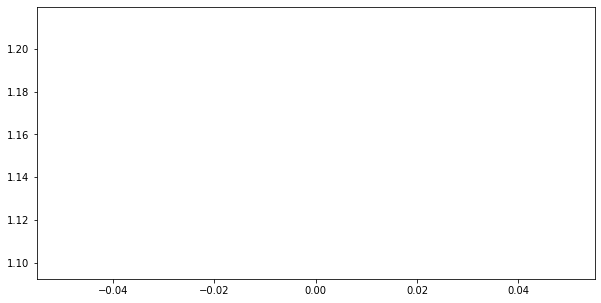

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_accumulator)
plt.show()

## Create functions to predict
In order to get the best recommendation use `predict_item`

In [12]:
def predict(user_id):
    """
    Predict a list of tuples ordered by value which are the model predictions
    """
    
    n_items = len(data_train['item_id'].unique())

    predictions = model.predict(
        torch.LongTensor([user_id for _ in range(n_items)]), 
        torch.LongTensor(list(range(n_items)))
    )

    tuple_predictions = [(i, predictions[i].item()) for i in range(len(predictions))]
    return sorted(tuple_predictions, key=lambda tup: tup[1], reverse=True)

In [13]:
predict(1)

[(3, 0.13428479433059692),
 (2, 0.08793289959430695),
 (0, 0.03742915391921997),
 (1, -0.0009737536311149597)]

In [14]:
def get_item(item_id):
    return activites.loc[item_id].to_dict()

def predict_item(user_id):
    """
    Returns the data of the item which has the best prediction score for a specific user
    """
    
    predictions = predict(user_id)
    first_item_idx = predictions[0][0]

    return get_item(first_item_idx)

predict_item(1)

{'id': 3,
 'type': 'sport',
 'description': 'climbing',
 'url': 'https://totem.ch/?ec',
 'lattitude': 46.51674945486285,
 'longitude': 6.548327486660693,
 'score': 4}